<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Xareny González,  Estefanía Meza, Alejandra Rico

**Fecha:** 14 de octubre del 2021.

**Expediente** : 720811, 729930, 720838.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: [Link con el enlace del repositorio del creador del proyecto](https://github.com/Xarenyglp/ProyectoM1_GonzalezX_MezaE_RicoA)

# Proyecto TEMA 1

## 1.1 Análisis de servicio a cliente

A lo largo de este análisis buscamos brindar un reporte de las métricas que maneja la empresa Tramites APF la cual se dedica a brindar servicios de gestion de Visas, pasaportes y Global Entry. Al finalizar este análisis la empresa podrá tener un panorama más claro de la eficiencia de sus trabajadores y asi lograr llevar a cabo los ajustes necesarios para que de esta manera mejore su servicio a cliente.

## 1.2 Objetivos

### Objetivo General

Evaluar de que manera y el tiempo que le toma a los trabajadores realizar cada una de sus actividades analizando metricas previamente proporcionadas por la empresa para que de esta manera ellos puedan optimizar sus recursos

### Objetivos Específicos

- Estimar tiempos de respuesta totales según la categoría de tipo de trámite.
- Identificar que trámites son los que se llevan a cabo en menor tiempo de acuerdo a cada trabajador
- Estimar el tiempo invertido en atención al cliente o tiempo invertido por trabajador

## 1.3 Definición del problema

> Tramites APF es una empresa dedicada a la gestión de trámites, por medio de ellos puedes llevar a cabo tu trámite de Visa, pasaporte o Global Entry de inicio a fin sin necesidad de invertir tanto tiempo en estos procesos los cuales resultan ser tediosos y muchas veces confusos. En el último año (durante la pandemia) Tramites APF creció de una manera exponencial. En diciembre 2019 sus clientes por mes eran al rededor de 300 y para finales del 2020 ya eran aproximadamente 2000. De esta manera se han visto en la obligación de mejorar sus procesos para lograr brindar el mejor servicio al cliente ya que es uno de los motivos por los cuales las personas acuden a ellos.
El plan es claramente continuar creciendo por lo que buscamos ofrecerle a la empresa estimaciones que la apoyen en la toma de decisiones.

## 1.4 Nodos y variables que se decidieron simular y porqué

1. Estimar los **tiempos invertido por servicio** según el **empleado** asignado.
    - Decidimos escoger estas variables o nodos ya que se encuentran relacionadas, el tiempo invertido depende directamente del empleado. 
    
2. Estimar los **tiempos de respuesta** dependiendo la **ubicación** de la orden de servicio.
    - El tiempo de respuesta es el tiempo que le toma al empleado atender el tramite desde el momento que se contacta, entonces esto depende de la ubicación del cliente.
    
3. Estimar los **tiempos totales de solución** según el **número total de visitas**.
    - El número de visitas y el tiempo de solución son factores de alta importancia, ya que son los que más afectados se ven en los resultados finales.
    
4. Estimar los **tiempos frente al cliente** según su **categoría**.
    - Dependiendo del tipo de trámite, analizar si éste requiere de más o menos tiempo invertido por el empleado.


<img src="df.jpg">

## 1.5 Definición de hipótesis y supuestos

### Hipótesis

Existe una gran correlación entre los nodos que se analizarán por lo que se buscará optimizar los tiempos de la empresa con el fin de disminuir costos y aumentar utilidades.
    



### Supuestos

- Los tiempos de respuesta excluyen la disponibilidad de citas en cada estado de la republica, o cualquier otra situación externa que pudiera retrasar el trámite.
- Ignoramos excepciones referentes a cada estado. 
    


## 1.6 Obtención de la base de datos

- **No. Cliente:** número identificador del cliente
- **Clave AA00:** número que identifica el trámite del cliente
- **Fecha recepción:** fecha en la que el cliente solicitó el servicio
- **Estatus:** estatus del trámite 
- **Categoría:** acción a realizar
- **Ubicación:** Estado de la República Mexicana donde se encuentra el cliente
- **Empleado:** nombre del ingeniero de servicio (IS) que atendió la orden de servicio
- **No. de consultas:** Número de veces que se le contactó al cliente
- **Fecha cierre:** fecha en la que se concluyó el trámite
- **T. transcurrido total:** tiempo en total que transcurrió desde que se inició el trámite hasta que se finalizó
- **Tiempo frente al cliente:** tiempo invertido por empleado
- **T. respuesta:** tiempo que transcurrió desde queel cliente contacto hasta que fue a su cita
- **Límite T. respuesta:** tiempo máximo acordado para asignación de cita
- **TST:** tiempo de solución total
- **Límite TST:** límite de tiempo de solución total
- **Cerrados el mismo día:** 1 si el tramite se concluyó el mismo dia, 0 si no.
- **TR OK:** 0 si no se resolvió dentro del límite del tiempo, y 1 si sí se resolvió dentro del límite de tiempo
- **Alcance TR:** es el resultado: 2-TR/TR límite
- **Alcance TST:** es el resultado: 2-TST/TST límite

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import KernelDensity
from scipy.stats import loglaplace 
from scipy.stats.distributions import norm
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde import KDEUnivariate
import matplotlib
from collections import defaultdict
from time import time
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from IPython.display import Markdown as md
from scipy.stats import cosine
from scipy.stats import logistic
from scipy.stats import dweibull
from scipy.stats import ncf

In [4]:
def kde_scipy_f(x, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return lambda x: kde.evaluate(x)

def kde_sklearn_f(x, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = lambda x_grid: np.exp(kde_skl.score_samples(x_grid[:, np.newaxis]))
    return log_pdf

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, 
                          bw='cv_ml',  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

functions = dict(zip(kde_funcnames, kde_funcs))


def plot_scaling(N=1000, bandwidth=0.1, rtol=0.0,
                 Nreps=3, kwds=None, xgrid=None):
    """
    Plot the time scaling of KDE algorithms.
    Either N, bandwidth, or rtol should be a 1D array.
    """
    if xgrid is None:
        xgrid = np.linspace(-10, 10, 5000)
    if kwds is None:
        kwds=dict()
    for name in functions:
        if name not in kwds:
            kwds[name] = {}
    times = defaultdict(list)
    
    B = np.broadcast(N, bandwidth, rtol)
    assert len(B.shape) == 1
    
    for N_i, bw_i, rtol_i in B:
        x = np.random.normal(size=int(N_i))
        kwds['Scikit-learn']['rtol'] = rtol_i
        for name, func in functions.items():
            t = 0.0
            for i in range(Nreps):
                t0 = time()
                func(x, xgrid, bw_i, **kwds[name])
                t1 = time()
                t += (t1 - t0)
            times[name].append(t / Nreps)
            
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'facecolor':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    plot_kwds={'linewidth':3, 'alpha':0.5}
    
    if np.size(N) > 1:
        for name in kde_funcnames:
            ax.loglog(N, times[name], label=name, **plot_kwds)
        ax.set_xlabel('Number of points')
    elif np.size(bandwidth) > 1:
        for name in kde_funcnames:
            ax.loglog(bandwidth, times[name], label=name, **plot_kwds)
        ax.set_xlabel('Bandwidth')
    elif np.size(rtol) > 1:
        for name in kde_funcnames:
            ax.loglog(rtol, times[name], label=name, **plot_kwds)
        ax.set_xlabel('Relative Tolerance')
        
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')
    ax.legend(loc=0)
    ax.set_ylabel('time (seconds)')
    ax.set_title('Execution time for KDE '
                 '({0} evaluations)'.format(len(xgrid)))
    
    return times


def plot_scaling_vs_kernel(kernels, N=1000, bandwidth=0.1, rtol=0.0,
                           Nreps=3, kwds=None, xgrid=None):
    """
    Plot the time scaling for Scikit-learn kernels.
    Either N, bandwidth, or rtol should be a 1D array.
    """
    if xgrid is None:
        xgrid = np.linspace(-10, 10, 5000)
    if kwds is None:
        kwds=dict()
    times = defaultdict(list)
    
    B = np.broadcast(N, bandwidth, rtol)
    assert len(B.shape) == 1
    
    for N_i, bw_i, rtol_i in B:
        x = np.random.normal(size=int(N_i))
        for kernel in kernels:
            kwds['kernel'] = kernel
            kwds['rtol'] = rtol_i
            t = 0.0
            for i in range(Nreps):
                t0 = time()
                kde_sklearn(x, xgrid, bw_i, **kwds)
                t1 = time()
                t += (t1 - t0)
            times[kernel].append(t / Nreps)
            
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'facecolor':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    plot_kwds={'linewidth':3, 'alpha':0.5}
    
    if np.size(N) > 1:
        for kernel in kernels:
            ax.loglog(N, times[kernel], label=kernel, **plot_kwds)
        ax.set_xlabel('Number of points')
    elif np.size(bandwidth) > 1:
        for kernel in kernels:
            ax.loglog(bandwidth, times[kernel], label=kernel, **plot_kwds)
        ax.set_xlabel('Bandwidth')
    elif np.size(rtol) > 1:
        for kernel in kernels:
            ax.loglog(rtol, times[kernel], label=kernel, **plot_kwds)
        ax.set_xlabel('Relative Tolerance')
        
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')
    ax.legend(loc=0)
    ax.set_ylabel('time (seconds)')
    ax.set_title('Execution time for KDE '
                 '({0} evaluations)'.format(len(xgrid)))
    return times


def plot_kernels():
    """Visualize the KDE kernels available in Scikit-learn"""
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'facecolor':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')

    X_src = np.zeros((1, 1))
    x_grid = np.linspace(-3, 3, 1000)

    for kernel in ['gaussian', 'tophat', 'epanechnikov',
                   'exponential', 'linear', 'cosine']:
        log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(x_grid[:, None])
        ax.plot(x_grid, np.exp(log_dens), lw=3, alpha=0.5, label=kernel)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(-2.9, 2.9)
    ax.legend()
    
    
# Función de aceptación y rechazo usando compresión de listas
def Acep_rechazo(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
#     R1 = np.random.rand(N)
    f_x = f(R1) #Evalua f en el vector R1
    t_x = t(R1) #Evalua t en el vector R1
    condition = R2*t_x <=f_x
    [plt.plot(R1[i],R2[i]*t_x[i],'ob') if condition[i] else plt.plot(R1[i],R2[i]*t_x[i],'o') \
         for i in range(len(R1))]              
    plt.show()
    
    
# Definimos la función para que nos diga el porcentaje de aceptadas en ambos casos
def histograma(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
#     R1 = np.random.rand(N)
    f_x = f(R1) #Evalua f en el vector R1
    t_x = t(R1) #Evalua t en el vector R1
    condition = R2*t_x <=f_x
    barras = [R1[i] for i in range(len(R1)) if condition[i]]
    plt.hist(barras,50,density=True)
    plt.xlabel('valores aleatorios')
    plt.ylabel('probabilidad')
    plt.title('histograma función creada')
    plt.show()
    return

In [16]:
data = pd.read_csv('tramitesapf.csv', encoding='latin1')
data.head(10)

,No. Cliente,Clave AA00,Fecha recepción,Estatus,Categoría,Ubicacion,Empleado,No. Consultas,Fecha cierre,T. transcurrido total,Tiempo frente al cliente,T. respuesta,Límite T. respuesta,TST,Límite TST,TR OK,Alcance TR,Alcance TST,Cerrados mismo dia
0,94830,09HB331426,30/09/20 23:59,RESUELTA,CM,JALISCO,CARLOS GUITIERREZ/800196,1,01/10/20 10:30,10.500000,0.500000,0.0,5,0.0,48,1,1.0,1.0,1
1,94829,09HB331586,30/09/20 22:15,RESUELTA,PERSONAL AT,JALISCO,HECTOR MARIN/800207,1,30/09/20 23:10,0.000000,0.500000,0.0,5,0.0,48,1,1.0,1.0,1
2,94828,09HB331608,30/09/20 20:31,RESUELTA,PERSONAL AT,JALISCO,HECTOR MARIN/800207,1,30/09/20 11:50,0.000000,0.666667,0.0,5,0.0,48,1,1.0,1.0,1
3,94827,09HB331507,30/09/20 18:47,RESUELTA,PERSONAL AT,JALISCO,HECTOR MARIN/800207,1,30/09/20 00:30,0.666667,0.666667,0.0,5,0.0,48,1,1.0,1.0,1
4,94826,0Y4X849031,30/09/20 17:03,RESUELTA,PERSONAL AT,JALISCO,HECTOR MARIN/800207,1,29/09/20 13:10,0.000000,0.750000,0.0,5,0.0,48,1,1.0,1.0,1
5,94825,09HB331503,30/09/20 15:19,RESUELTA,PERSONAL AT,JALISCO,HECTOR MARIN/800207,1,29/09/20 01:50,0.000000,0.666667,0.0,5,0.0,48,1,1.0,1.0,1
6,94824,09HB331586,30/09/20 13:35,RESUELTA,PERSONAL AT,JALISCO,HECTOR MARIN/800207,1,28/09/20 14:30,0.583333,0.583333,0.0,5,0.0,48,1,1.0,1.0,1
7,94823,09HB331608,30/09/20 11:51,RESUELTA,PERSONAL AT,JALISCO,HECTOR MARIN/800207,1,28/09/20 03:10,0.000000,0.533333,0.0,5,0.0,48,1,1.0,1.0,1
8,94822,02TX062449,30/09/20 10:07,RESUELTA,PERSONAL AT,JALISCO,HECTOR MARIN/800207,1,27/09/20 15:50,0.000000,0.500000,0.0,5,0.0,48,1,1.0,1.0,1
9,94821,02TX062470,30/09/20 08:23,RESUELTA,PERSONAL AT,JALISCO,HECTOR MARIN/800207,1,27/09/20 04:30,0.000000,0.583333,0.0,5,0.0,48,1,1.0,1.0,1


In [17]:
tiempoT= pd.DataFrame(data,columns=['T. transcurrido total'])
tiempoC= pd.DataFrame(data,columns=['Tiempo frente al cliente'])
tiempoR= pd.DataFrame(data,columns=['T. respuesta'])
TST= pd.DataFrame(data,columns=['TST'])

In [18]:
Tiempos=tiempoT.join(tiempoC).join(tiempoR).join(TST)
Tiempos.head(80)
TST= pd.DataFrame(data,columns=['TST'])
promedio = Tiempos.mean()
des = Tiempos.std()
data_estd = (Tiempos - promedio)/des
data_estd.head(10)

,T. transcurrido total,Tiempo frente al cliente,T. respuesta,TST
0,-0.180376,-0.336437,-0.27994,-0.297862
1,-0.332195,-0.336437,-0.27994,-0.297862
2,-0.332195,-0.228733,-0.27994,-0.297862
3,-0.322556,-0.228733,-0.27994,-0.297862
4,-0.332195,-0.174881,-0.27994,-0.297862
5,-0.332195,-0.228733,-0.27994,-0.297862
6,-0.323761,-0.282585,-0.27994,-0.297862
7,-0.332195,-0.314896,-0.27994,-0.297862
8,-0.332195,-0.336437,-0.27994,-0.297862
9,-0.332195,-0.282585,-0.27994,-0.297862


# Tiempos totales de solución

In [19]:
NV = data.groupby(['Ubicacion']).mean()
prom_TT = NV['T. transcurrido total']
prom_TT.head(10)

Ubicacion
AGUASCALIENTES         20.597081
BAJA CALIFORNIA        52.314035
BAJA CALIFORNIA SUR    38.760963
CAMPECHE               90.793478
CHIAPAS                47.215065
CHIHUAHUA              13.301872
CIUDAD DE MEXICO       21.386747
COAHUILA               13.283731
COLIMA                 17.699579
DURANGO                16.008010
Name: T. transcurrido total, dtype: float64

In [22]:
x_grid = np.linspace(5, 50, 1000)
x = prom_TT

<ipython-input-23-9cf523ef083e>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(x[:, None])


{'bandwidth': 1.0}


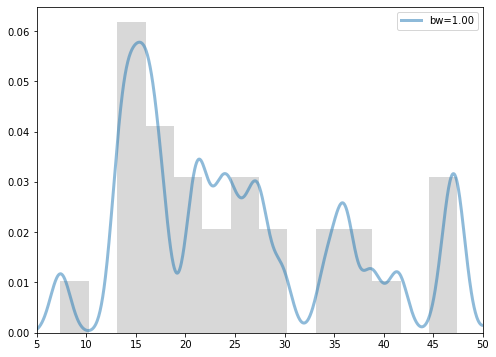

In [23]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper right')
ax.set_xlim(5, 50);

# Método de aceptación y rechazo

In [25]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    pdf = lambda x: np.exp(kde_skl.score_samples(x[:, np.newaxis]))
    return pdf

El máximo de f es: 0.05777304290053099


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


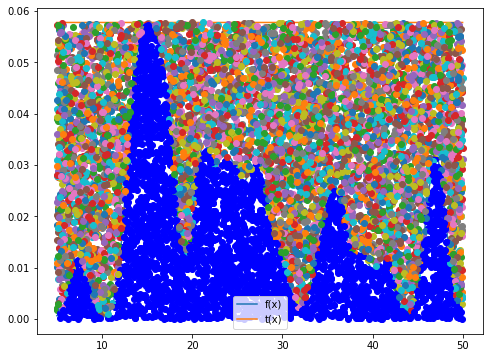

In [29]:
# Función objetivo 
x_grid = np.linspace(5, 50, 1000)
data3 = np.asarray(prom_TT)
f = kde_sklearn(data3, x_grid, bandwidth=1)
# Máximo de la función f
max_f = max(f(x))
# Función t
t = lambda x: max_f*np.ones(len(x))
x = np.arange(5,50,0.01)  # Rango donde se graficará las funciones
print('El máximo de f es:',max_f)
# Gráficas de las funciones
plt.figure(figsize=(8,6))
plt.plot(x,f(x),label='f(x)')
plt.plot(x,t(x),label='t(x)')
plt.legend()

# Validación del método
N = 10000 # número de puntos a simular
R2 = np.random.rand(N)
R1 = np.random.uniform(5,50,N)

Acep_rechazo(R2,R1,f,t)

> Se generaron 10,000 muestras aleatorias con el método de aceptación y rechazo según la distribución de probabilidad obtenida con el Kernel Density Estimation.

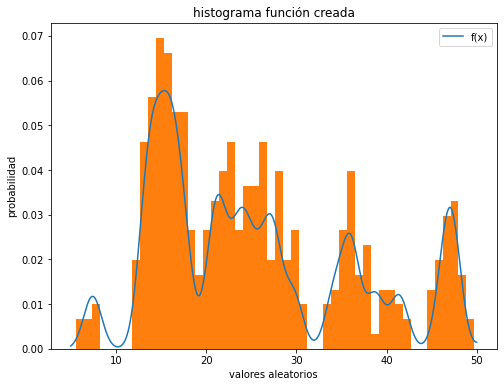

In [28]:
# Función objetivo 
f = kde_sklearn(data3, x_grid, bandwidth=1)
x = np.arange(5,50,0.01) # Rango donde se graficará las funciones
# Gráfica de la función
plt.figure(figsize=(8,6))
plt.plot(x,f(x),label='f(x)')
plt.legend()

t = lambda x: max_f*np.ones(len(x))
N = 1000
R2 = np.random.rand(N)
R1 = np.random.uniform(5,50,N)
histograma(R2, R1, f, t)

## Prueba de Kolmogorov-Smirnov


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:781: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - 

[1.5894882807362874e-05,
 1.8091566239558517e-05,
 1.6419697839382525e-05,
 1.6444890430870422e-05,
 1.6269346513936383e-05,
 2.3625338249164187e-05,
 1.6280775830540193e-05,
 1.5024033536930554e-05,
 2.0182297637049075e-05,
 1.7382907182311687e-05,
 1.572692400563501e-05]

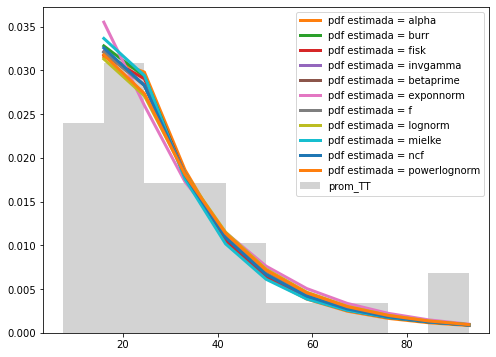

In [32]:
dist_to = ['alpha','burr','fisk','invgamma','betaprime','exponnorm','f','lognorm','mielke','ncf','powerlognorm',]
e = []

plt.figure(figsize=(8,6))

[y, x, _] = plt.hist(prom_TT, bins=10, density=True, label='prom_TT',fc='lightgray')
x = x[1:]

for dist in dist_to:
    param = getattr(st,dist).fit(prom_TT)
    
    pdf = getattr(st, dist).pdf(x, *param)
    
    plt.plot(x, pdf, linewidth=3,label='pdf estimada = '+ str(dist))
    
    plt.legend();
    
    e.append(((y-pdf)**2).mean())
    
e


En base a los resultados obtenidos en la gráfica anterior podemos notar que las distribuciones que presentan un menor error son las siguientes:
- **LOGNORM** 
- **POWERLOGNORM**
- **ALPHA**

In [34]:
results = []
for i in dist_to:
    dist = getattr(st, i)
    param = dist.fit(prom_TT)
    a = st.kstest(prom_TT, i, args=param)
    results.append((i,a[0],a[1]))
    
    
results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:781: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1797: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))


exponnorm: statistic=0.0775480507454504, pvalue=0.9768520720614928
ncf: statistic=0.07831416027357138, pvalue=0.9746270192364641
powerlognorm: statistic=0.07971275767750613, pvalue=0.9702082587887927
lognorm: statistic=0.08080108933768904, pvalue=0.9664437397379548
fisk: statistic=0.08224934015511329, pvalue=0.9609826220220601
invgamma: statistic=0.08257110568954279, pvalue=0.9596984955590082
mielke: statistic=0.08260380559886044, pvalue=0.9595665453926852
betaprime: statistic=0.0826617786871035, pvalue=0.9593319555248497
f: statistic=0.08267103555377076, pvalue=0.9592944194391283
burr: statistic=0.08276255257617574, pvalue=0.9589221682020429
alpha: statistic=0.09036755176303982, pvalue=0.9206227377294584


### NCF

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1797: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Text(0.5, 1.0, 'Usando paquete scipy')

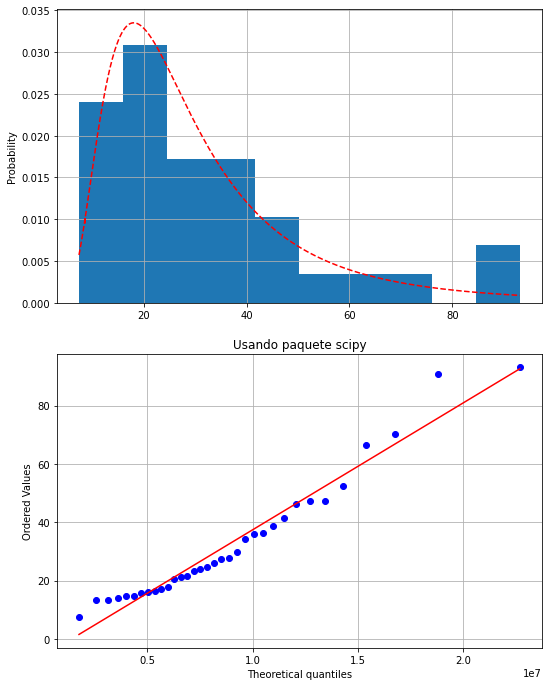

In [45]:
measurements2 = prom_TT
# Histograma de las variables creadas
divisiones = 10 # Cantidad de barras en el histograma
fig, ax = plt.subplots(2,1, figsize=(8,10))
fig.tight_layout(pad=3.0)

ax[0].hist(measurements2,divisiones,density=True)

# Función de distribución de probabilidad la cual creemos que mis datos distribuyen 
# RECORDAR: SÓLO FUNCIONA PARA DISTRIBUCIONES CONTINUAS
dist = 'ncf'
params = getattr(st, dist).fit(measurements2)

# Graficar PDF de la distribución que queremos probar

x = np.arange(measurements2.min(), measurements2.max(), .01)
y = getattr(st, dist).pdf(x, *params)
ax[0].plot(x,y,'r--')
ax[0].set_ylabel('Probability')
ax[0].grid()

# gráfica de Q-Q entre mis datos y la curva que quiero probar que sigue mi distribución (dist)
# Usando scipy
grap2 = st.probplot(measurements2, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
ax[1].grid()
ax[1].set_title('Usando paquete scipy')


### POWERLOGNORM

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6503: RuntimeWarning: divide by zero encountered in power
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6503: RuntimeWarning: overflow encountered in power
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6502: RuntimeWarning: invalid value encountered in multiply
  return (c/(x*s) * _norm_pdf(np.log(x)/s) *


Text(0.5, 1.0, 'Usando paquete scipy')

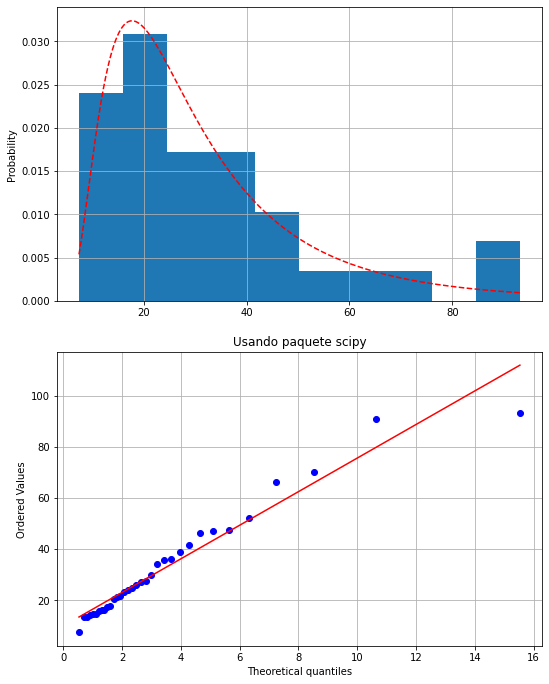

In [47]:
measurements2 = prom_TT
# Histograma de las variables creadas
divisiones = 10 # Cantidad de barras en el histograma
fig, ax = plt.subplots(2,1, figsize=(8,10))
fig.tight_layout(pad=3.0)

ax[0].hist(measurements2,divisiones,density=True)

# Función de distribución de probabilidad la cual creemos que mis datos distribuyen 
# RECORDAR: SÓLO FUNCIONA PARA DISTRIBUCIONES CONTINUAS
dist = 'powerlognorm'
params = getattr(st, dist).fit(measurements2)

# Graficar PDF de la distribución que queremos probar

x = np.arange(measurements2.min(), measurements2.max(), .01)
y = getattr(st, dist).pdf(x, *params)
ax[0].plot(x,y,'r--')
ax[0].set_ylabel('Probability')
ax[0].grid()

# gráfica de Q-Q entre mis datos y la curva que quiero probar que sigue mi distribución (dist)
# Usando scipy
grap2 = st.probplot(measurements2, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
ax[1].grid()
ax[1].set_title('Usando paquete scipy')


### LOGNORM

Text(0.5, 1.0, 'Usando paquete scipy')

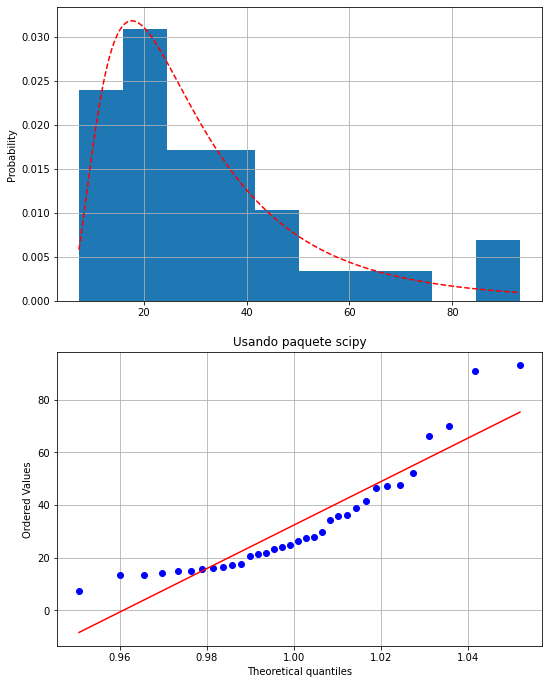

In [46]:
measurements2 = prom_TT
# Histograma de las variables creadas
divisiones = 10 # Cantidad de barras en el histograma
fig, ax = plt.subplots(2,1, figsize=(8,10))
fig.tight_layout(pad=3.0)

ax[0].hist(measurements2,divisiones,density=True)

# Función de distribución de probabilidad la cual creemos que mis datos distribuyen 
# RECORDAR: SÓLO FUNCIONA PARA DISTRIBUCIONES CONTINUAS
dist = 'lognorm'
params = getattr(st, dist).fit(measurements2)

# Graficar PDF de la distribución que queremos probar

x = np.arange(measurements2.min(), measurements2.max(), .01)
y = getattr(st, dist).pdf(x, *params)
ax[0].plot(x,y,'r--')
ax[0].set_ylabel('Probability')
ax[0].grid()

# gráfica de Q-Q entre mis datos y la curva que quiero probar que sigue mi distribución (dist)
# Usando scipy
grap2 = st.probplot(measurements2, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
ax[1].grid()
ax[1].set_title('Usando paquete scipy')


> Por lo tanto, NCF es la distribución de probabilidad que mejor se ajusta a nuestros datos, ya que la cola derecha tiene un mayor peso que la izquierda.

## La prueba chi cuadrado

## 1.8 Conclusiones

## Referencias